# Visualisation des données

In [21]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from statsmodels.stats.proportion import proportion_confint
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
plt.rcParams['figure.figsize'] = [15, 8]

In [22]:
engine = create_engine('sqlite:///Data/data.db', echo=False)
con = engine.connect()
clean_df = pd.read_sql('select * from clean_data', con=con)
con.close()
clean_df.pcr.fillna("Not tested", inplace=True)

## Australian state information (population and area size)
## downloaded from https://www.worldatlas.com/articles/which-australian-states-territories-have-the-highest-density-of-population.html
australia_state_population = pd.read_csv("Data/state_info.csv", sep=";")
australia_state_population

,state_name,clean_state,state_population,state_area,state_density
0,Australian Capital Territory,act,390800,2280,"171,4"
1,Victoria,vic,5938100,227416,"26,11"
2,New South Wales,nsw,7618200,800641,"9,52"
3,Tasmania,tas,516600,68401,"7,55"
4,Queensland,qld,4779400,1730647,"2,76"
5,South Australia,sa,1698600,983482,"1,73"
6,Western Australia,wa,2591600,2529875,"1,2"
7,Northern Territory,nt,244600,1349129,"0,18"


In [23]:
## Load map data for map plotting
state_map = geopandas.read_file('Data/state_shapefiles/States Map.shp') # source https://www.arcgis.com/home/item.html?id=66e2eac498084e218dee3a8a7f625f5f
state_map['clean_state'] = state_map.ISO_SUB.str.lower() ## create a formatted state name column which uses same standard as our clean dataset. 
postcode_map = geopandas.read_file('Data/postcode_shapefiles/aus_poas.shp') # source https://github.com/edifierxuhao/Sydney_Airbnb_Exploration

In [24]:
clean_df.head()

,index,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,...,phone_number,address_2,test,estimated_age,clean_state,state_match_score,source_state,state_code,is_valid_phone_number,pcr
0,17199,998607,kye,rollins,40.0,kangaroo court,duncraig,2450,qld,19731223.0,...,04 19919085,None,1973-12-23 00:00:00.000000,46.0,qld,100.0,qld,nsw,0,Positive
1,16564,242290,chantelle,alderman,45.0,None,corrimal,4610,wa,19100327.0,...,04 65278098,None,1910-03-27 00:00:00.000000,110.0,wa,100.0,wa,qld,0,Positive
2,4310,202239,liam,beelitz,18.0,kellway street,mermaid waters,2840,qld,19770305.0,...,08 84768009,yaraan,1977-03-05 00:00:00.000000,43.0,qld,100.0,qld,nsw,0,Positive
3,13233,651250,aidyn,fernando,26.0,eggleston crescent,bluff,3754,nsw,19390418.0,...,04 59903074,None,1939-04-18 00:00:00.000000,80.0,nsw,100.0,nsw,vic,0,Positive
4,8829,783189,hanna,thandi,31.0,amagula avenue,labrador,2580,vic,19650226.0,...,03 66497842,fraser lodge,1965-02-26 00:00:00.000000,55.0,vic,100.0,vic,nsw,0,Positive


## Visualisation des données par age 

### Répartition des ages dans la population étudiée

In [25]:
by_age_pcr_results = clean_df.groupby(['age', 'pcr'], ).size().reset_index()
by_age_pcr_results.rename({0: 'count'}, axis=1, inplace=True)
by_age_pcr_results.age = by_age_pcr_results.age.astype(int)

Text(0.5, 1.0, 'PCR test results by age')

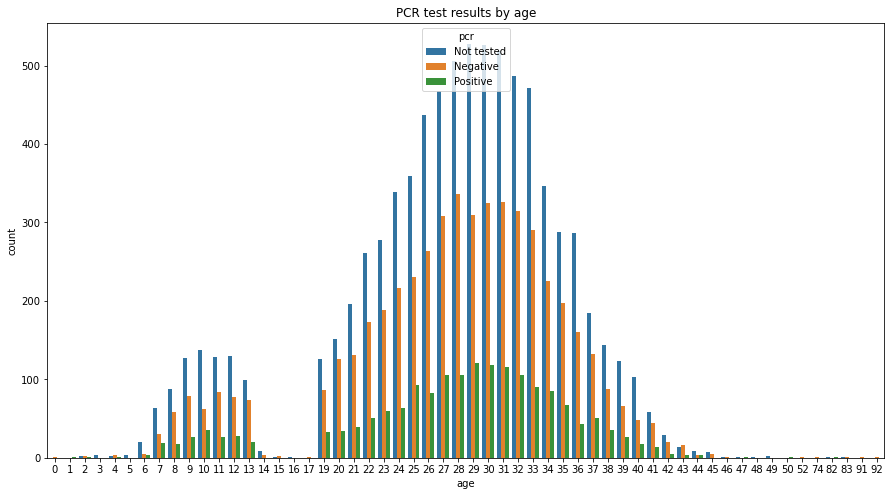

In [26]:
ax = sns.barplot(data=by_age_pcr_results, x='age', y='count', hue='pcr', hue_order = ['Not tested', 'Negative', 'Positive'])
ax.set_title("PCR test results by age")

La distribution des ages a deux modes : un autours de 10 ans et un atour de 30 ans. C'est une pyramide des ages inattendue (en particulier le fait qu'on n'est quasiment pas de données entre 14 et 17 ands). Cela est probablement révélateur d'un biais dans l'acquisition des données initiales. 

### Etude du taux de positivité des tests en fonction de l'âge

In [27]:
clean_df['age_bins'] = pd.cut(x=clean_df['age'], bins=[0, 15, 25, 30, 35, 40])
by_age_bins_pcr_results = clean_df.groupby(['age_bins', 'pcr']).size().reset_index()
by_age_bins_pcr_results.rename({0: 'count'}, axis=1, inplace=True)
positivity_rate = pd.pivot_table(by_age_bins_pcr_results, values='count', index='age_bins', columns=['pcr'])
positivity_rate.reset_index(inplace=True)
positivity_rate['Tested'] = positivity_rate.Positive + positivity_rate.Negative
positivity_rate['positivity_rate'] = positivity_rate.Positive/positivity_rate.Tested
## Estimate positivity rate confidence interval. 
positivity_rate['conf_int'] = positivity_rate.\
        apply(lambda row: proportion_confint(row['Positive'], row['Tested'], method='normal'), axis=1)
positivity_rate

pcr,age_bins,Negative,Not tested,Positive,Tested,positivity_rate,conf_int
0,"(0, 15]",481,816,179,660,0.271212,"(0.23729404268024637, 0.30513019974399613)"
1,"(15, 25]",1155,1712,374,1529,0.244604,"(0.22305846535066648, 0.2661501677428587)"
2,"(25, 30]",1542,2464,532,2074,0.256509,"(0.23771456628824883, 0.2753037557946827)"
3,"(30, 35]",1353,2111,463,1816,0.254956,"(0.23491059367769246, 0.2750013005954353)"
4,"(35, 40]",494,841,174,668,0.260479,"(0.22719611618389424, 0.2937619676484411)"


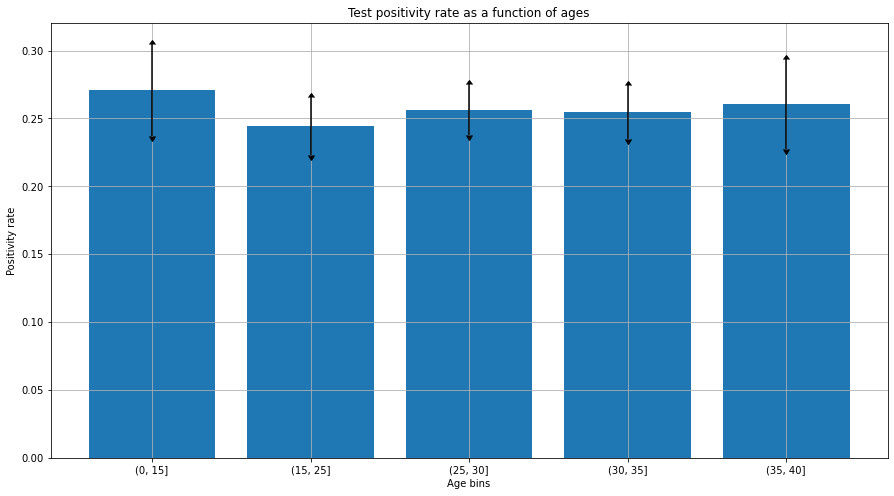

In [28]:
positivity_rate['error_inf'] = positivity_rate.apply(lambda x: x['positivity_rate'] - x['conf_int'][0], axis=1)
positivity_rate['error_sup'] = positivity_rate.apply(lambda x: x['conf_int'][1] - x['positivity_rate'], axis=1)
errors = np.transpose(np.asarray([[x['error_inf'], x['error_sup']] for _, x in positivity_rate.iterrows()]))

plt.bar(positivity_rate.age_bins.astype(str), positivity_rate.positivity_rate)
plt.errorbar(positivity_rate.age_bins.astype(str), positivity_rate.positivity_rate, yerr=errors, 
             linestyle='', uplims=True, lolims=True, color='black')
plt.xlabel("Age bins")
plt.ylabel("Positivity rate")
plt.title("Test positivity rate as a function of ages")
plt.grid()

Le taux de positivité au test est entre 25% et 26%. Il n'y a pas d'influence significative de l'âge sur le taux de positivité. 

## Visualisation des données par état

### Taux de positivité par état

In [29]:
by_state_pcr_results = clean_df.groupby(['clean_state', 'pcr'], ).size().reset_index()
by_state_pcr_results.rename({0: 'count'}, axis=1, inplace=True)
positivity_rate = pd.pivot_table(by_state_pcr_results, values='count', index='clean_state', columns=['pcr'])
positivity_rate.reset_index(inplace=True)
positivity_rate['Tested'] = positivity_rate.Positive + positivity_rate.Negative
## Estimate positivity rate confidence interval. 
positivity_rate['positivity_rate'] = positivity_rate.Positive/positivity_rate.Tested
positivity_rate['conf_int'] = positivity_rate.\
        apply(lambda row: proportion_confint(row['Positive'], row['Tested'], method='binom_test'), axis=1)
# Not here we use binomial test to estimate positiity rates confidence interval because the state
# "Northern territory (nt)" has a very small tested population.
positivity_rate

pcr,clean_state,Negative,Not tested,Positive,Tested,positivity_rate,conf_int
0,act,88,116,31,119,0.260504,"(0.1882213537561583, 0.34828137279199745)"
1,nsw,1923,3221,645,2568,0.251168,"(0.2345867789217849, 0.2684690454892815)"
2,nt,45,79,4,49,0.081633,"(0.016893878445635127, 0.1703204378362831)"
3,qld,1125,1778,392,1517,0.258405,"(0.23693168623499405, 0.2811045632741058)"
4,sa,463,724,134,597,0.224456,"(0.19247681594057364, 0.2595892981789287)"
5,tas,165,245,59,224,0.263393,"(0.20943955803954628, 0.32563794402306)"
6,vic,1396,2174,517,1913,0.270256,"(0.25061370315944886, 0.29061172121124906)"
7,wa,530,780,186,716,0.259777,"(0.2275463601982856, 0.2918129735653511)"


Text(0.5, 1.0, 'PCR number of test results by state')

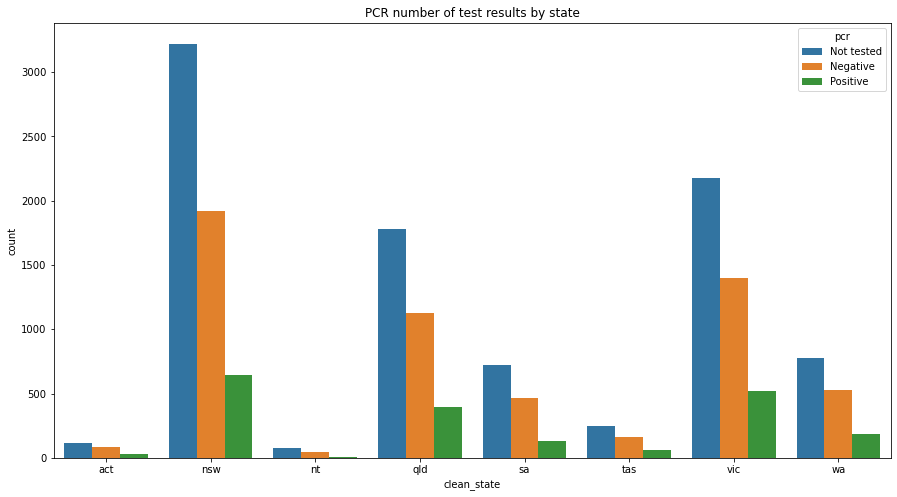

In [30]:
ax = sns.barplot(data=by_state_pcr_results, x='clean_state', y='count', hue='pcr', hue_order = ['Not tested', 'Negative', 'Positive'])
ax.set_title("PCR number of test results by state")

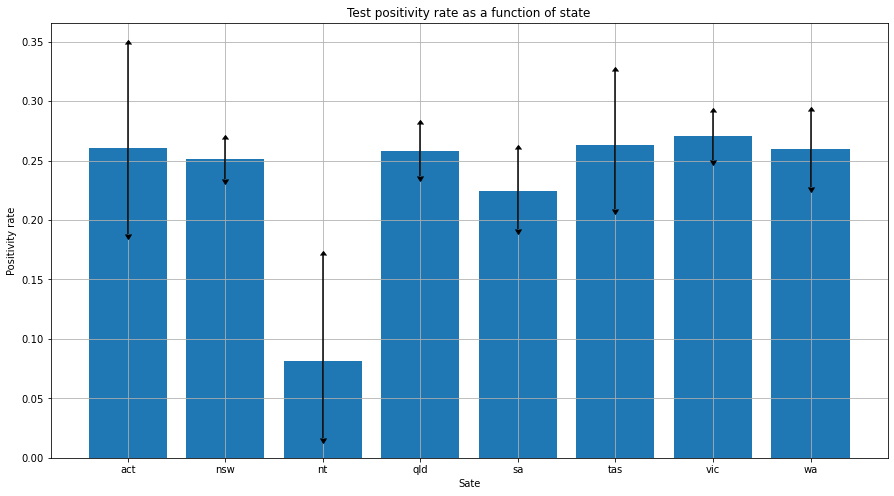

In [31]:
positivity_rate['error_inf'] = positivity_rate.apply(lambda x: x['positivity_rate'] - x['conf_int'][0], axis=1)
positivity_rate['error_sup'] = positivity_rate.apply(lambda x: x['conf_int'][1] - x['positivity_rate'], axis=1)
errors = np.transpose(np.asarray([[x['error_inf'], x['error_sup']] for _, x in positivity_rate.iterrows()]))

plt.bar(positivity_rate.clean_state, positivity_rate.positivity_rate)
plt.errorbar(positivity_rate.clean_state, positivity_rate.positivity_rate, yerr=errors, 
             linestyle='', uplims=True, lolims=True, color='black')
plt.xlabel("Sate")
plt.ylabel("Positivity rate")
plt.title("Test positivity rate as a function of state")
plt.grid()

Le taux de positivité est significativement plus bas en "Nother territory" (a noté qu'il y a aussi eu très peu de tests dans cette région, l'estimation du taux de positivité est donc très incertaine). Cette état est aussi le moins dense d'Australie (https://www.worldatlas.com/articles/which-australian-states-territories-have-the-highest-density-of-population.html) ce qui peu expliqué que le virus soit moins présent. Il est intéressant de regardant le taux pourcentage de la population infecté par état. 

In [32]:
# Compute the proportion of population infected by stage
positivity_rate = positivity_rate.merge(australia_state_population, on='clean_state')
positivity_rate['pourc_infected'] = positivity_rate.Positive/positivity_rate.state_population * 1000000

In [33]:
positivity_rate

,clean_state,Negative,Not tested,Positive,Tested,positivity_rate,conf_int,error_inf,error_sup,state_name,state_population,state_area,state_density,pourc_infected
0,act,88,116,31,119,0.260504,"(0.1882213537561583, 0.34828137279199745)",0.072283,0.087777,Australian Capital Territory,390800,2280,"171,4",79.324463
1,nsw,1923,3221,645,2568,0.251168,"(0.2345867789217849, 0.2684690454892815)",0.016581,0.017301,New South Wales,7618200,800641,"9,52",84.665669
2,nt,45,79,4,49,0.081633,"(0.016893878445635127, 0.1703204378362831)",0.064739,0.088688,Northern Territory,244600,1349129,"0,18",16.353230
3,qld,1125,1778,392,1517,0.258405,"(0.23693168623499405, 0.2811045632741058)",0.021473,0.022700,Queensland,4779400,1730647,"2,76",82.018663
4,sa,463,724,134,597,0.224456,"(0.19247681594057364, 0.2595892981789287)",0.031979,0.035134,South Australia,1698600,983482,"1,73",78.888496
5,tas,165,245,59,224,0.263393,"(0.20943955803954628, 0.32563794402306)",0.053953,0.062245,Tasmania,516600,68401,"7,55",114.208285
6,vic,1396,2174,517,1913,0.270256,"(0.25061370315944886, 0.29061172121124906)",0.019642,0.020356,Victoria,5938100,227416,"26,11",87.064886
7,wa,530,780,186,716,0.259777,"(0.2275463601982856, 0.2918129735653511)",0.032230,0.032036,Western Australia,2591600,2529875,"1,2",71.770335


### Visualisation des mêmes données sous la forme de cartes

Text(0.5, 1.0, 'Number of Covid19 positive cases by state')

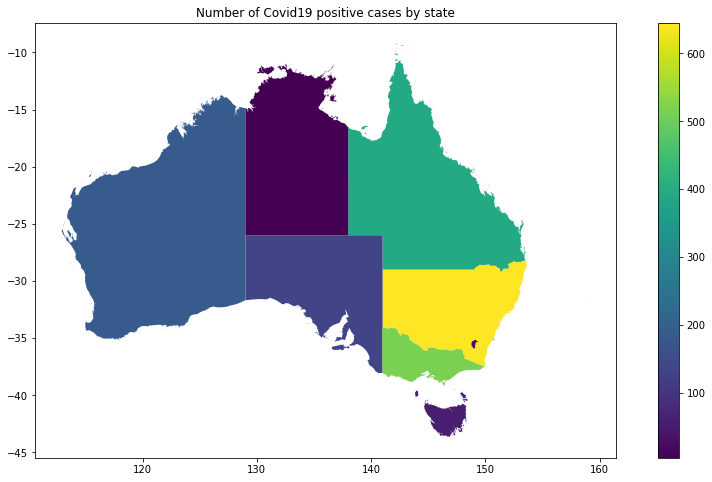

In [34]:
state_map_merged = state_map.merge(positivity_rate, on='clean_state')
state_map_merged.plot(column='Positive', legend=True)
plt.title("Number of Covid19 positive cases by state")

Text(0.5, 1.0, 'Number of infected individuals for 10^6 inhabitants')

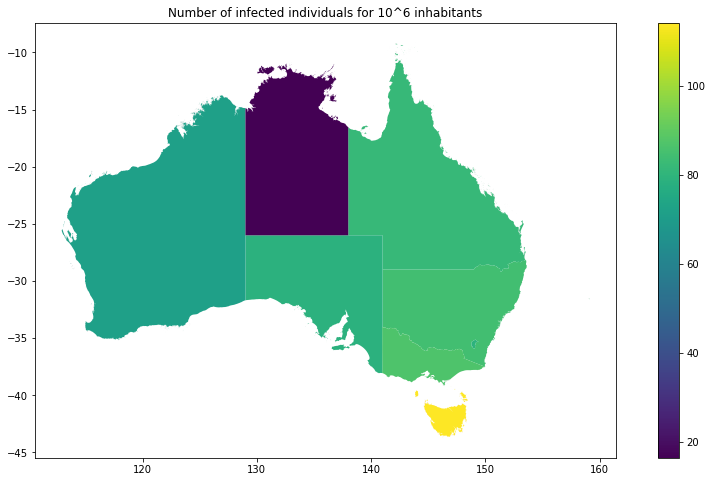

In [35]:
state_map_merged.plot(column='pourc_infected', legend=True)
plt.title("Number of infected individuals for 10^6 inhabitants")

On constate que l'état "Northern territory" est le moins infecté ce qui est cohérent de ce qu'on avait observé sur les taux de positivité au test. Par ailleurs, l'île de tasmania est très touché par l'épidémie. 

## Visualisation des données en fonction du code postal

In [36]:
postcode_pcr = clean_df.groupby(['postcode', 'pcr'], ).size().reset_index()
postcode_pcr.rename({0: 'count'}, axis=1, inplace=True)
postcode_pcr = pd.pivot_table(postcode_pcr, values='count', index='postcode', columns=['pcr'], fill_value=0)
postcode_pcr.reset_index(inplace=True)
postcode_pcr['Tested'] = postcode_pcr.Positive + postcode_pcr.Negative
#postcode_pcr.postcode = postcode_pcr.postcode.astype(int)

In [37]:
postcode_map_merged = postcode_map.merge(postcode_pcr, left_on='POA_NAME', how='left', right_on='postcode')
postcode_map_merged[['Positive', 'Negative', 'Tested']] = postcode_map_merged[['Positive', 'Negative', 'Tested']].fillna(0)

Text(0.5, 1.0, 'Number of person tested by postcode')

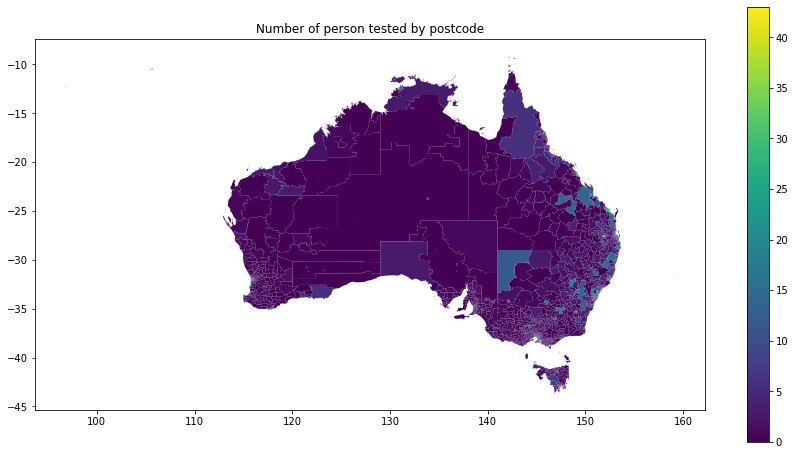

In [38]:
postcode_map_merged.plot(column='Tested', legend=True)
plt.title("Number of person tested by postcode")

Ce graphe manque un peu d'intérêt car la granularité est trop fine. On peut cependant constater un plus grand nombre de tests faits le long des côtes et autours des grandes villes tels que Sydney et Brisbane. 